<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="figures/PDSH-cover-small.png">

*This notebook contains an excerpt from the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas; the content is available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).*

*The text is released under the [CC-BY-NC-ND license](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode), and code is released under the [MIT license](https://opensource.org/licenses/MIT). If you find this content useful, please consider supporting the work by [buying the book](http://shop.oreilly.com/product/0636920034919.do)!*

<!--NAVIGATION-->
< [In Depth: Principal Component Analysis](05.09-Principal-Component-Analysis.ipynb) | [Contents](Index.ipynb) | [In Depth: k-Means Clustering](05.11-K-Means.ipynb) >

<a href="https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.10-Manifold-Learning.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>


# In-Depth: Manifold Learning

We have seen how principal component analysis (PCA) can be used in the dimensionality reduction task—reducing the number of features of a dataset while maintaining the essential relationships between the points.
While PCA is flexible, fast, and easily interpretable, it does not perform so well when there are *nonlinear* relationships within the data; we will see some examples of these below.

To address this deficiency, we can turn to a class of methods known as *manifold learning*—a class of unsupervised estimators that seeks to describe datasets as low-dimensional manifolds embedded in high-dimensional spaces.
When you think of a manifold, I'd suggest imagining a sheet of paper: this is a two-dimensional object that lives in our familiar three-dimensional world, and can be bent or rolled in that two dimensions.
In the parlance of manifold learning, we can think of this sheet as a two-dimensional manifold embedded in three-dimensional space.

Rotating, re-orienting, or stretching the piece of paper in three-dimensional space doesn't change the flat geometry of the paper: such operations are akin to linear embeddings.
If you bend, curl, or crumple the paper, it is still a two-dimensional manifold, but the embedding into the three-dimensional space is no longer linear.
Manifold learning algorithms would seek to learn about the fundamental two-dimensional nature of the paper, even as it is contorted to fill the three-dimensional space.

Here we will demonstrate a number of manifold methods, going most deeply into a couple techniques: multidimensional scaling (MDS), locally linear embedding (LLE), and isometric mapping (IsoMap).

We begin with the standard imports:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## Manifold Learning: "HELLO"

To make these concepts more clear, let's start by generating some two-dimensional data that we can use to define a manifold.
Here is a function that will create data in the shape of the word "HELLO":

In [2]:
def make_hello(N=1000, rseed=42):
    # Make a plot with "HELLO" text; save as PNG
    fig, ax = plt.subplots(figsize=(4, 1))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.text(0.5, 0.4, 'HELLO', va='center', ha='center', weight='bold', size=85)
    fig.savefig('hello.png')
    plt.close(fig)
    
    # Open this PNG and draw random points from it
    from matplotlib.image import imread
    data = imread('hello.png')[::-1, :, 0].T
    rng = np.random.RandomState(rseed)
    X = rng.rand(4 * N, 2)
    i, j = (X * data.shape).astype(int).T
    mask = (data[i, j] < 1)
    X = X[mask]
    X[:, 0] *= (data.shape[0] / data.shape[1])
    X = X[:N]
    return X[np.argsort(X[:, 0])]

Let's call the function and visualize the resulting data:

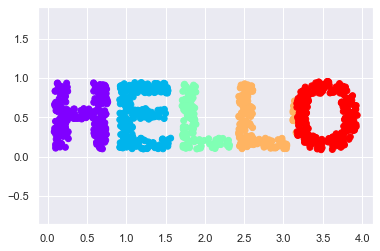

In [3]:
X = make_hello(1000)
colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 5))
plt.scatter(X[:, 0], X[:, 1], **colorize)
plt.axis('equal');

The output is two dimensional, and consists of points drawn in the shape of the word, "HELLO".
This data form will help us to see visually what these algorithms are doing.

## Multidimensional Scaling (MDS)

Looking at data like this, we can see that the particular choice of *x* and *y* values of the dataset are not the most fundamental description of the data: we can scale, shrink, or rotate the data, and the "HELLO" will still be apparent.
For example, if we use a rotation matrix to rotate the data, the *x* and *y* values change, but the data is still fundamentally the same:

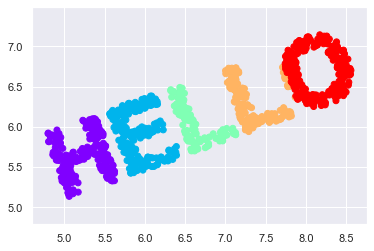

In [4]:
def rotate(X, angle):
    theta = np.deg2rad(angle)
    R = [[np.cos(theta), np.sin(theta)],
         [-np.sin(theta), np.cos(theta)]]
    return np.dot(X, R)
    
X2 = rotate(X, 20) + 5
plt.scatter(X2[:, 0], X2[:, 1], **colorize)
plt.axis('equal');

This tells us that the *x* and *y* values are not necessarily fundamental to the relationships in the data.
What *is* fundamental, in this case, is the *distance* between each point and the other points in the dataset.
A common way to represent this is to use a distance matrix: for $N$ points, we construct an $N \times N$ array such that entry $(i, j)$ contains the distance between point $i$ and point $j$.
Let's use Scikit-Learn's efficient ``pairwise_distances`` function to do this for our original data:

In [5]:
from sklearn.metrics import pairwise_distances
D = pairwise_distances(X)
D.shape

(1000, 1000)

As promised, for our *N*=1,000 points, we obtain a 1000×1000 matrix, which can be visualized as shown here:

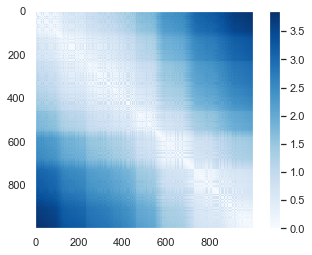

In [6]:
plt.imshow(D, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar();

If we similarly construct a distance matrix for our rotated and translated data, we see that it is the same:

In [7]:
D2 = pairwise_distances(X2)
np.allclose(D, D2)

True

This distance matrix gives us a representation of our data that is invariant to rotations and translations, but the visualization of the matrix above is not entirely intuitive.
In the representation shown in this figure, we have lost any visible sign of the interesting structure in the data: the "HELLO" that we saw before.

Further, while computing this distance matrix from the (x, y) coordinates is straightforward, transforming the distances back into *x* and *y* coordinates is rather difficult.
This is exactly what the multidimensional scaling algorithm aims to do: given a distance matrix between points, it recovers a $D$-dimensional coordinate representation of the data.
Let's see how it works for our distance matrix, using the ``precomputed`` dissimilarity to specify that we are passing a distance matrix:

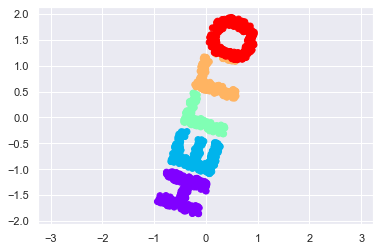

In [7]:
from sklearn.manifold import MDS
model = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
out = model.fit_transform(D)
plt.scatter(out[:, 0], out[:, 1], **colorize)
plt.axis('equal');

The MDS algorithm recovers one of the possible two-dimensional coordinate representations of our data, using *only* the $N\times N$ distance matrix describing the relationship between the data points.

## MDS as Manifold Learning

The usefulness of this becomes more apparent when we consider the fact that distance matrices can be computed from data in *any* dimension.
So, for example, instead of simply rotating the data in the two-dimensional plane, we can project it into three dimensions using the following function (essentially a three-dimensional generalization of the rotation matrix used earlier):

In [8]:
def random_projection(X, dimension=3, rseed=42):
    assert dimension >= X.shape[1]
    rng = np.random.RandomState(rseed)
    C = rng.randn(dimension, dimension)
    e, V = np.linalg.eigh(np.dot(C, C.T))
    return np.dot(X, V[:X.shape[1]])
    
X3 = random_projection(X, 3)
X3.shape

(1000, 3)

Let's visualize these points to see what we're working with:

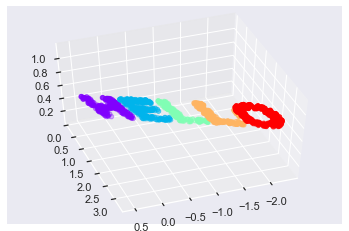

In [9]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(X3[:, 0], X3[:, 1], X3[:, 2],
             **colorize)
ax.view_init(azim=70, elev=50)

We can now ask the ``MDS`` estimator to input this three-dimensional data, compute the distance matrix, and then determine the optimal two-dimensional embedding for this distance matrix.
The result recovers a representation of the original data:

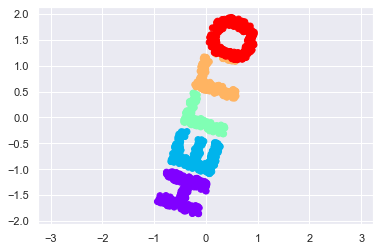

In [10]:
model = MDS(n_components=2, random_state=1)
out3 = model.fit_transform(X3)
plt.scatter(out3[:, 0], out3[:, 1], **colorize)
plt.axis('equal');

This is essentially the goal of a manifold learning estimator: given high-dimensional embedded data, it seeks a low-dimensional representation of the data that preserves certain relationships within the data.
In the case of MDS, the quantity preserved is the distance between every pair of points.

## Nonlinear Embeddings: Where MDS Fails

Our discussion thus far has considered *linear* embeddings, which essentially consist of rotations, translations, and scalings of data into higher-dimensional spaces.
Where MDS breaks down is when the embedding is nonlinear—that is, when it goes beyond this simple set of operations.
Consider the following embedding, which takes the input and contorts it into an "S" shape in three dimensions:

In [11]:
def make_hello_s_curve(X):
    t = (X[:, 0] - 2) * 0.75 * np.pi
    x = np.sin(t)
    y = X[:, 1]
    z = np.sign(t) * (np.cos(t) - 1)
    return np.vstack((x, y, z)).T

XS = make_hello_s_curve(X)

This is again three-dimensional data, but we can see that the embedding is much more complicated:

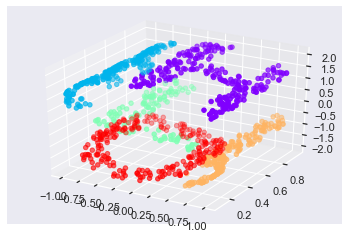

In [12]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2],
             **colorize);

The fundamental relationships between the data points are still there, but this time the data has been transformed in a nonlinear way: it has been wrapped-up into the shape of an "S."

If we try a simple MDS algorithm on this data, it is not able to "unwrap" this nonlinear embedding, and we lose track of the fundamental relationships in the embedded manifold:

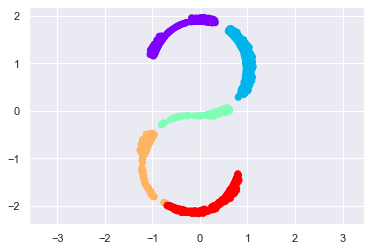

In [13]:
from sklearn.manifold import MDS
model = MDS(n_components=2, random_state=2)
outS = model.fit_transform(XS)
plt.scatter(outS[:, 0], outS[:, 1], **colorize)
plt.axis('equal');

The best two-dimensional *linear* embeding does not unwrap the S-curve, but instead throws out the original y-axis.

## Nonlinear Manifolds: Locally Linear Embedding

How can we move forward here? Stepping back, we can see that the source of the problem is that MDS tries to preserve distances between faraway points when constructing the embedding.
But what if we instead modified the algorithm such that it only preserves distances between nearby points?
The resulting embedding would be closer to what we want.

Visually, we can think of it as illustrated in this figure:

![(LLE vs MDS linkages)](figures/05.10-LLE-vs-MDS.png)
[figure source in Appendix](06.00-Figure-Code.ipynb#LLE-vs-MDS-Linkages)

Here each faint line represents a distance that should be preserved in the embedding.
On the left is a representation of the model used by MDS: it tries to preserve the distances between each pair of points in the dataset.
On the right is a representation of the model used by a manifold learning algorithm called locally linear embedding (LLE): rather than preserving *all* distances, it instead tries to preserve only the distances between *neighboring points*: in this case, the nearest 100 neighbors of each point.

Thinking about the left panel, we can see why MDS fails: there is no way to flatten this data while adequately preserving the length of every line drawn between the two points.
For the right panel, on the other hand, things look a bit more optimistic. We could imagine unrolling the data in a way that keeps the lengths of the lines approximately the same.
This is precisely what LLE does, through a global optimization of a cost function reflecting this logic.

LLE comes in a number of flavors; here we will use the *modified LLE* algorithm to recover the embedded two-dimensional manifold.
In general, modified LLE does better than other flavors of the algorithm at recovering well-defined manifolds with very little distortion:

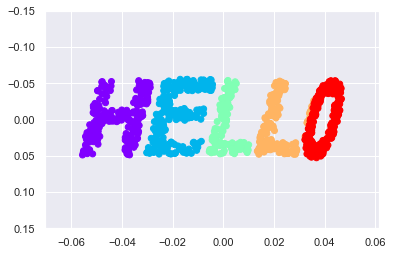

In [14]:
from sklearn.manifold import LocallyLinearEmbedding
model = LocallyLinearEmbedding(n_neighbors=100, n_components=2, method='modified',
                               eigen_solver='dense')
out = model.fit_transform(XS)

fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1], **colorize)
ax.set_ylim(0.15, -0.15);

The result remains somewhat distorted compared to our original manifold, but captures the essential relationships in the data!

## Some Thoughts on Manifold Methods

Though this story and motivation is compelling, in practice manifold learning techniques tend to be finicky enough that they are rarely used for anything more than simple qualitative visualization of high-dimensional data.

The following are some of the particular challenges of manifold learning, which all contrast poorly with PCA:

- In manifold learning, there is no good framework for handling missing data. In contrast, there are straightforward iterative approaches for missing data in PCA.
- In manifold learning, the presence of noise in the data can "short-circuit" the manifold and drastically change the embedding. In contrast, PCA naturally filters noise from the most important components.
- The manifold embedding result is generally highly dependent on the number of neighbors chosen, and there is generally no solid quantitative way to choose an optimal number of neighbors. In contrast, PCA does not involve such a choice.
- In manifold learning, the globally optimal number of output dimensions is difficult to determine. In contrast, PCA lets you find the output dimension based on the explained variance.
- In manifold learning, the meaning of the embedded dimensions is not always clear. In PCA, the principal components have a very clear meaning.
- In manifold learning the computational expense of manifold methods scales as O[N^2] or O[N^3]. For PCA, there exist randomized approaches that are generally much faster (though see the [megaman](https://github.com/mmp2/megaman) package for some more scalable implementations of manifold learning).

With all that on the table, the only clear advantage of manifold learning methods over PCA is their ability to preserve nonlinear relationships in the data; for that reason I tend to explore data with manifold methods only after first exploring them with PCA.

Scikit-Learn implements several common variants of manifold learning beyond Isomap and LLE: the Scikit-Learn documentation has a [nice discussion and comparison of them](http://scikit-learn.org/stable/modules/manifold.html).
Based on my own experience, I would give the following recommendations:

- For toy problems such as the S-curve we saw before, locally linear embedding (LLE) and its variants (especially *modified LLE*), perform very well. This is implemented in ``sklearn.manifold.LocallyLinearEmbedding``.
- For high-dimensional data from real-world sources, LLE often produces poor results, and isometric mapping (IsoMap) seems to generally lead to more meaningful embeddings. This is implemented in ``sklearn.manifold.Isomap``
- For data that is highly clustered, *t-distributed stochastic neighbor embedding* (t-SNE) seems to work very well, though can be very slow compared to other methods. This is implemented in ``sklearn.manifold.TSNE``.

If you're interested in getting a feel for how these work, I'd suggest running each of the methods on the data in this section.

## Example: Isomap on Faces

One place manifold learning is often used is in understanding the relationship between high-dimensional data points.
A common case of high-dimensional data is images: for example, a set of images with 1,000 pixels each can be thought of as a collection of points in 1,000 dimensions – the brightness of each pixel in each image defines the coordinate in that dimension.

Here let's apply Isomap on some faces data.
We will use the Labeled Faces in the Wild dataset, which we previously saw in [In-Depth: Support Vector Machines](05.07-Support-Vector-Machines.ipynb) and [In Depth: Principal Component Analysis](05.09-Principal-Component-Analysis.ipynb).
Running this command will download the data and cache it in your home directory for later use:

In [16]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=30)
faces.data.shape

(2370, 2914)

We have 2,370 images, each with 2,914 pixels.
In other words, the images can be thought of as data points in a 2,914-dimensional space!

Let's quickly visualize several of these images to see what we're working with:

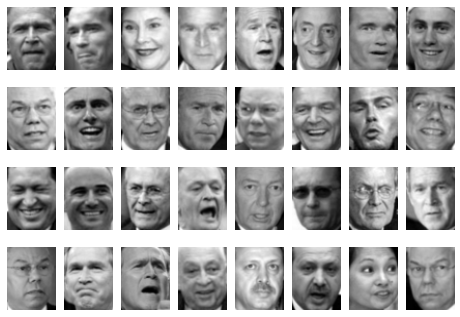

In [17]:
fig, ax = plt.subplots(4, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gray')

We would like to plot a low-dimensional embedding of the 2,914-dimensional data to learn the fundamental relationships between the images.
One useful way to start is to compute a PCA, and examine the explained variance ratio, which will give us an idea of how many linear features are required to describe the data:

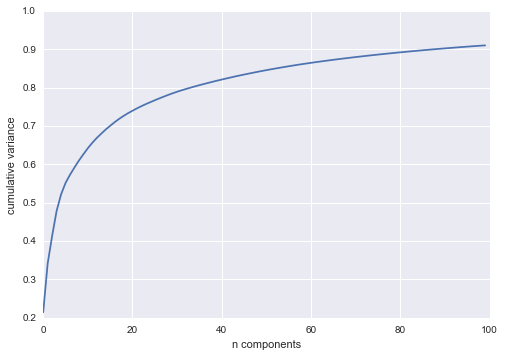

In [18]:
from sklearn.decomposition import RandomizedPCA
model = RandomizedPCA(100).fit(faces.data)
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel('n components')
plt.ylabel('cumulative variance');

We see that for this data, nearly 100 components are required to preserve 90% of the variance: this tells us that the data is intrinsically very high dimensional—it can't be described linearly with just a few components.

When this is the case, nonlinear manifold embeddings like LLE and Isomap can be helpful.
We can compute an Isomap embedding on these faces using the same pattern shown before:

In [19]:
from sklearn.manifold import Isomap
model = Isomap(n_components=2)
proj = model.fit_transform(faces.data)
proj.shape

(2370, 2)

The output is a two-dimensional projection of all the input images.
To get a better idea of what the projection tells us, let's define a function that will output image thumbnails at the locations of the projections:

In [20]:
from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

Calling this function now, we see the result:

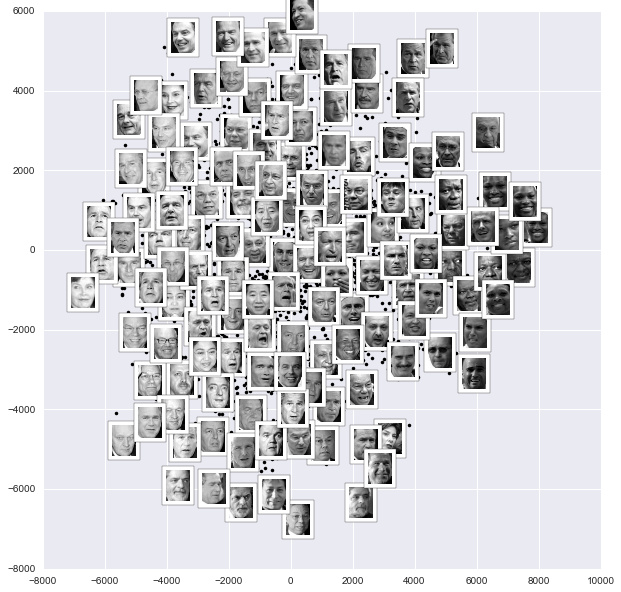

In [21]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data,
                model=Isomap(n_components=2),
                images=faces.images[:, ::2, ::2])

The result is interesting: the first two Isomap dimensions seem to describe global image features: the overall darkness or lightness of the image from left to right, and the general orientation of the face from bottom to top.
This gives us a nice visual indication of some of the fundamental features in our data.

We could then go on to classify this data (perhaps using manifold features as inputs to the classification algorithm) as we did in [In-Depth: Support Vector Machines](05.07-Support-Vector-Machines.ipynb).

## Example: Visualizing Structure in Digits

As another example of using manifold learning for visualization, let's take a look at the MNIST handwritten digits set.
This data is similar to the digits we saw in [In-Depth: Decision Trees and Random Forests](05.08-Random-Forests.ipynb), but with many more pixels per image.
It can be downloaded from http://mldata.org/ with the Scikit-Learn utility:

In [22]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist.data.shape

(70000, 784)

This consists of 70,000 images, each with 784 pixels (i.e. the images are 28×28).
As before, we can take a look at the first few images:

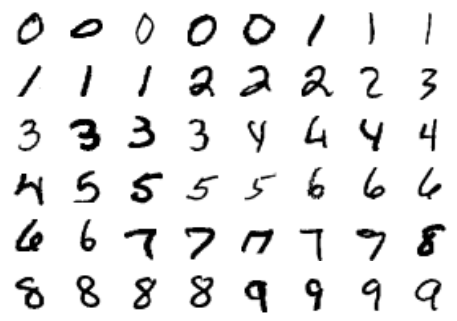

In [23]:
fig, ax = plt.subplots(6, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(mnist.data[1250 * i].reshape(28, 28), cmap='gray_r')

This gives us an idea of the variety of handwriting styles in the dataset.

Let's compute a manifold learning projection across the data.
For speed here, we'll only use 1/30 of the data, which is about ~2000 points
(because of the relatively poor scaling of manifold learning, I find that a few thousand samples is a good number to start with for relatively quick exploration before moving to a full calculation):

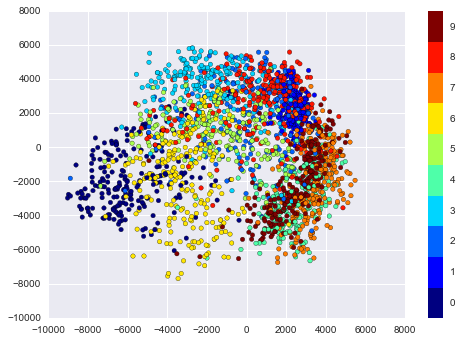

In [24]:
# use only 1/30 of the data: full dataset takes a long time!
data = mnist.data[::30]
target = mnist.target[::30]

model = Isomap(n_components=2)
proj = model.fit_transform(data)
plt.scatter(proj[:, 0], proj[:, 1], c=target, cmap=plt.cm.get_cmap('jet', 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5);

The resulting scatter plot shows some of the relationships between the data points, but is a bit crowded.
We can gain more insight by looking at just a single number at a time:

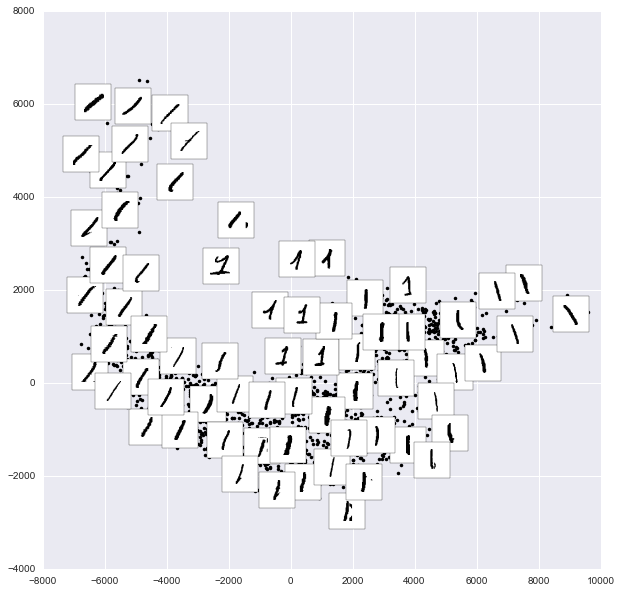

In [25]:
from sklearn.manifold import Isomap

# Choose 1/4 of the "1" digits to project
data = mnist.data[mnist.target == 1][::4]

fig, ax = plt.subplots(figsize=(10, 10))
model = Isomap(n_neighbors=5, n_components=2, eigen_solver='dense')
plot_components(data, model, images=data.reshape((-1, 28, 28)),
                ax=ax, thumb_frac=0.05, cmap='gray_r')

The result gives you an idea of the variety of forms that the number "1" can take within the dataset.
The data lies along a broad curve in the projected space, which appears to trace the orientation of the digit.
As you move up the plot, you find ones that have hats and/or bases, though these are very sparse within the dataset.
The projection lets us identify outliers that have data issues: for example, pieces of the neighboring digits that snuck into the extracted images.

Now, this in itself may not be useful for the task of classifying digits, but it does help us get an understanding of the data, and may give us ideas about how to move forward, such as how we might want to preprocess the data before building a classification pipeline.

<!--NAVIGATION-->
< [In Depth: Principal Component Analysis](05.09-Principal-Component-Analysis.ipynb) | [Contents](Index.ipynb) | [In Depth: k-Means Clustering](05.11-K-Means.ipynb) >

<a href="https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.10-Manifold-Learning.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>
